# Basic design of RF systems

S. Albright, H. Damerau, L. Intelisano, A. Lasheen, D. Quartullo, F. Tecker, C. Völlinger, M. Zampetakis

## Links

- Introductory CAS website: https://indico.cern.ch/event/1356988/
- Programme of the CAS: https://indico.cern.ch/event/1356988/attachments/2789484/5122442/Timetable_Introductory2024_ver5.pdf
- Python software installation for transverse (and longitudinal) exercises: https://github.com/cerncas/hands-on-python/blob/main/Setup_Instructions.md
- Longitudinal hands-on, link to content and cheat sheets: https://indico.cern.ch/event/1356988/contributions/5713283/

# Introduction

In this hands-on session we will either
- design the RF system of a proton synchrotron, the superconduding SPS (scSPS)
- or develop the RF system for a hypothetical beam energy and current upgrade of an electron storage ring (Soleil).

**Please make your choice according to your interest.**

## Useful formula for bucket area reduction factor depending on stable phase
- Bucket area reduction ratio depending on stable phase
- Use approximation (S. Y. Lee book, p. 242): $\alpha(\phi_\mathrm{S}) \simeq \cfrac{1 - \sin \phi_\mathrm{S}}{1 + \sin \phi_\mathrm{S}}$

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as sciCont

# Upgrade the CERN-SPS to higher energy as an injector for the Future Circular Collider (FCC)

### Design an RF system optimized for the Superconducting Super Proton Synchrotron (scSPS)
(see, e.g. <a href="https://indico.cern.ch/event/591312/contributions/2386529/attachments/1379193/2133450/scSPS_Note_v2.pdf">F. Burkart et al., SPS energy upgrade considerations</a>)

In this hands-on session we will design the RF system for a proton synchrotron.

The goal of the session is to calculate the relevant longitudinal parameters.

The notebook is constructed with the following purpose in mind:

1. Design a linear acceleration cycle in bending field which determines average energy gain per turn and stable phase.
2. Knowing energy gain per turn and the number of particles accelerated, the average RF power to the beam is calculated.
3. Injection and extraction energies also fix the revolution frequencies and, in combination with the harmonic number, define the the RF frequency range.
4. The acceleration of a bunch with a given size in the longitudinal phase space, i.e. longitudinal emttance, requires a sufficient bucket area. This area is defined by the RF voltage. Interesting effects occur around the energy of transiton crossing, which also deserves a more detailed look.
5. With the knowledge of frequency and voltage the fundamental reqirements are set. Look for existing RF systems in particle accelerators and suggest your design. No calculations are needed for these parameter estimates. However please justify your choice(s).
6. The energy transfer does not only take place from the cavity to the beam, but also the beam may induce significant voltage back into the cavity. This phenomenon has been introduced as beam loading.
7. New RF systems for particle accelerators are rarely designed from scratch, but inspired by existing installations. Compare your RF system design with the existing one of the CERN SPS, as well as with the RF system of the now-decommissioned Tevatron, or any other RF system you may find.

**Basic parameters of the superconducting Proton Synchrotron (scSPS) at CERN**

| Parameter                        |                                                                     |
| -------------------------------- | ------------------------------------------------------------------- |
| Energy range                     | $E_\mathrm{kin} = 13.1\,\mathrm{GeV}\ldots1300\,\mathrm{GeV}$       |
| Circumference                    | $2 \pi R = 6911.5\,\mathrm{m}$                                      |
| Bending radius                   | $\rho = 741.3\,\mathrm{m}$                                          |
| Transition gamma                 | $\gamma_\mathrm{tr} = 18$                                           |
| Acceleration time                | $4\,\mathrm{s}$                                                     |
| Longitudinal emittance per bunch | $\varepsilon_\mathrm{l} = 0.4\,\mathrm{eVs}\ldots0.5\,\mathrm{eVs}$ |
| Maximum bucket filling factor    | $\varepsilon_\mathrm{l}/A_\mathrm{bucket} = 0.8$                    |
| Total beam intensity             | $N = 1 \cdot 10^{13} \,\mathrm{protons}$                            |
| Minimum bunch spacing            | $25 \,\mathrm{ns}$                                                  |

## Exercise 1: Average energy gain and stable phase

- How much energy does the particle gain during each turn assuming a constant ramp rate in bending field, $B$?
    - Assume a linear acceleration ramp $dB/dt = \mathrm{const.}$

#### &hookrightarrow; Helpful Hints &hookleftarrow;
1. Convert the given energies, $E = m_0 \gamma c^2$, at injection and extraction to momenta, $p = m_0 \beta \gamma c$. Note that the common unit for energy is eV, and the unit for momentum is eV/c, hence also the particle mass is most handy in units of eV.
2. Use the momentum to calculate the required bending field at injection and extraction.
3. Assuming a linear ramp, the ramp rate is just given by extraction minus injection field, divided by the acceleration time.

In [2]:
injectionEnergy = 13.1E9 #eV
extractionEnergy = 1.3E12 #eV

c0 = sciCont.c
e0 = sciCont.e
protonMass = sciCont.physical_constants['proton mass energy equivalent in MeV'][0]*1E6
protonCharge = 1 #e

momentumInjection = np.sqrt((protonMass + injectionEnergy)**2 - protonMass**2)
momentumExtraction = np.sqrt((protonMass + extractionEnergy)**2 - protonMass**2)

print("Momentum at injection:  "+str(momentumInjection/1E9) +" GeV/c")
print("Momentum at extraction: "+str(momentumExtraction/1E9) +" GeV/c")

Momentum at injection:  14.00688147696667 GeV/c
Momentum at extraction: 1300.9379337344328 GeV/c


In [3]:
circumference = 2*np.pi*1100 #m
bendingRadius = 741.3        #m
accelerationDuration = 4     #s

magneticFieldInjection = momentumInjection / (c0*bendingRadius*protonCharge)
magneticFieldExtraction = momentumExtraction / (c0*bendingRadius*protonCharge)
averageBDot = (magneticFieldExtraction - magneticFieldInjection)/accelerationDuration

print("Average B-Dot: "+str(averageBDot)+" T/s")

Average B-Dot: 1.4477067045348289 T/s


- What would the stable phase be for an RF voltage of 20 MV? 

#### &hookrightarrow; Helpful Hints &hookleftarrow;
1. Derive the average energy gain per turn from the ramp rate.
2. The bunch must be placed at a stable phase such that the RF voltage exactly matches required energy gain per turn.

In [4]:
averageEnergyGainPerTurn = 2*np.pi*protonCharge*circumference/(2*np.pi)*bendingRadius*averageBDot
print("Average per turn energy gain: "+str(averageEnergyGainPerTurn/1e6)+" MeV")

Average per turn energy gain: 7.417322108539338 MeV


In [5]:
rfVoltage = 20000E3 #V
stablePhase = np.arcsin(averageEnergyGainPerTurn/rfVoltage)
print("Stable phase angle: "+str(180/np.pi*stablePhase)+" deg")

Stable phase angle: 21.769042161823684 deg


## Exercise 2: Power transfer to the beam

- How much power is transferred from the RF system to the beam?

Keep in mind that power is nothing but an change of energy within a given time, the duration of the acceleration.

In [6]:
nProtons = 1E13
energyGainJoules = (extractionEnergy - injectionEnergy)*e0*nProtons
averagePowerToBeam = energyGainJoules / accelerationDuration
print("Average power to beam: "+str(averagePowerToBeam/1E3)+" kW")

Average power to beam: 515.4602775736499 kW


## Exercise 3: RF frequency and harmonic

- Choose RF frequency and harmonic of the RF system.
- Note a few arguments for your choice.
- What is the frequency range of the RF system?

#### &hookrightarrow; Helpful Hints &hookleftarrow;
1. Calculate the revolution frequencies at injection and extraction to derive the revolution and RF frequency swing.
2. Suggest an RF frequency which is appropriate for the filling pattern. There is no unique solution, everything depends on the arguments.

In [7]:
betaInjection = np.sqrt(1 - (protonMass/(protonMass + injectionEnergy))**2)
betaExtraction = np.sqrt(1 - (protonMass/(protonMass + extractionEnergy))**2)

print(f"beta injection: {betaInjection}, beta extraction: {betaExtraction}")

beta injection: 0.9977639262869249, beta extraction: 0.9999997399156176


In [8]:
revolutionFrequencyInjection = c0*betaInjection/circumference
revolutionFrequencyExtraction = c0*betaExtraction/circumference

print("Revolution frequency at injection:  "+str(revolutionFrequencyInjection/1E3)+ "kHz")
print("Revolution frequency at extraction: "+str(revolutionFrequencyExtraction/1E3)+ "kHz")

Revolution frequency at injection:  43.278873452276045kHz
Revolution frequency at extraction: 43.375853802587116kHz


#### Arguments for choice of RF frequency
- 25 ns bunch spacing suggests multiples of 40 MHz

### Choice of harmonic number

#### &hookrightarrow; Helpful Hints &hookleftarrow;
Again, many solutions are possible. Your beam dynamics and engineering arguments count!

In [9]:
flatTopRFFrequency = 1/25E-9
harmonicNumber = flatTopRFFrequency/revolutionFrequencyExtraction
print("40 MHz/revolution frequency at extraction: "+str(harmonicNumber))
harmonicNumber = int(round(harmonicNumber))
print("Nearest integer harmonic number, h = "+str(harmonicNumber))
print("Present SPS RF systems runs at h = 4620 (corresponding to 200 MHz)")

40 MHz/revolution frequency at extraction: 922.172049501288
Nearest integer harmonic number, h = 922
Present SPS RF systems runs at h = 4620 (corresponding to 200 MHz)


#### RF frequency swing

#### &hookrightarrow; Helpful Hints &hookleftarrow;
The difference between lowest and highest frequency of an RF cavity is also referred to as tuning range.

In [10]:
injectionRFFrequency = harmonicNumber * revolutionFrequencyInjection
extractionRFFrequency = harmonicNumber * revolutionFrequencyExtraction

frequencySwingFRev = revolutionFrequencyExtraction - revolutionFrequencyInjection
frequencySwingRF = extractionRFFrequency - injectionRFFrequency

print("Revolution frequency swing: "+str(frequencySwingFRev/1E3)+" kHz ("+str(100*frequencySwingFRev/revolutionFrequencyInjection)+" %)")
print("RF frequency swing: "+str(frequencySwingRF/1E3)+" kHz")

Revolution frequency swing: 0.09698035031107428 kHz (0.2240824276953865 %)
RF frequency swing: 89.41588298681378 kHz


## Exercise 4: Calculate bucket area during the cycle, determine RF voltage along the cycle

- Plot momentum, kinetic energy and revolution frequency (and/or further parameters) during the cycle.
- Calculate and plot the bucket area along the cycle and choose an RF voltage such that a bunch with $0.45\,\mathrm{eVs}$ longitudinal emittance can be comfortably accelerated, e.g $\varepsilon_\mathrm{l}/A_\mathrm{bucket} \simeq 0.8$.
- Zoom around transition crossing. What happens there?

In [11]:
longitudinalEmittance = 0.45 #eVs
targetFillingFactor = 0.8
targetBucketArea = longitudinalEmittance / targetFillingFactor

print("Target bucket area: "+str(targetBucketArea)+" eVs")

Target bucket area: 0.5625 eVs


#### Momentum, energy and revolution frequency during cycle

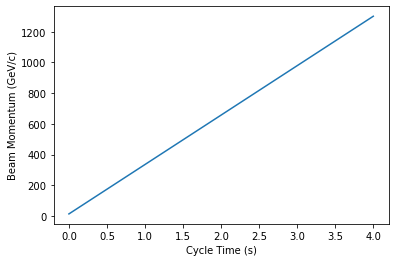

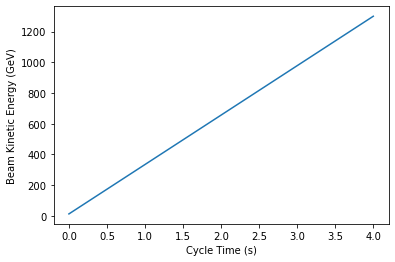

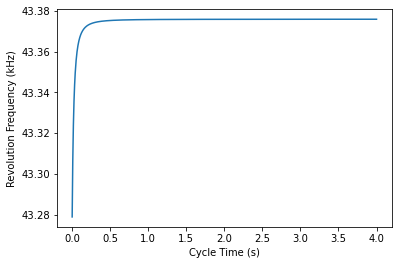

In [12]:
import matplotlib.pyplot as plt

timeRange = np.linspace(0, accelerationDuration, 1000)
BFieldRange = np.linspace(magneticFieldInjection, magneticFieldExtraction, len(timeRange))
momentumRange = protonCharge*bendingRadius*BFieldRange*c0

plt.figure()
plt.plot(timeRange, momentumRange/1e9)
plt.xlabel("Cycle Time (s)")
plt.ylabel("Beam Momentum (GeV/c)")
plt.show()

energyRange = np.sqrt(momentumRange**2 + protonMass**2)

plt.figure()
plt.plot(timeRange, (energyRange - protonMass)/1E9)
plt.xlabel("Cycle Time (s)")
plt.ylabel("Beam Kinetic Energy (GeV)")
plt.show()

betaRange = momentumRange/energyRange
gammaRange = 1/np.sqrt(1-betaRange**2)

fRevRange = c0*betaRange/circumference

plt.figure()
plt.plot(timeRange, fRevRange/1e3)
plt.xlabel("Cycle Time (s)")
plt.ylabel("Revolution Frequency (kHz)")
plt.show()

#### Bucket area reduction factor

#### &hookrightarrow; Helpful Hints &hookleftarrow;
Define an auxiliary function for the bucket area reduction due to the energy loss per turn.

In [13]:
def reduction_ratio(deltaE, voltage):    
    phis = np.arcsin(deltaE/voltage)
    return (1-np.sin(phis))/(1+np.sin(phis))

#### Bucket area

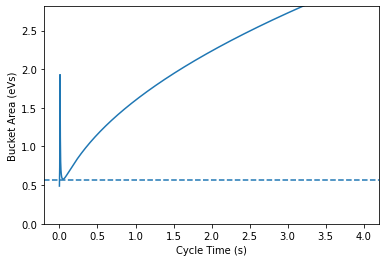

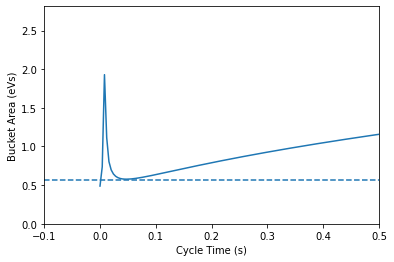

In [14]:
rfHarmonic = 4620
rfVoltage = 20E6 #V
gamma_T = 18

timeRange = np.linspace(0, accelerationDuration, 1000)
BFieldRange = np.linspace(magneticFieldInjection, magneticFieldExtraction, len(timeRange))
momentumRange = protonCharge*bendingRadius*BFieldRange*c0
energyRange = np.sqrt(momentumRange**2 + protonMass**2)
gammaRange = 1/np.sqrt(1-betaRange**2)
phaseSlipFactor = 1/gamma_T**2 - 1/gammaRange**2

reductionFactor = reduction_ratio(averageEnergyGainPerTurn, rfVoltage)

bucketAreaRange = 4/c0*circumference*np.sqrt((2*energyRange*rfVoltage)/ \
                                             (np.pi**3*rfHarmonic**3*np.abs(phaseSlipFactor))) \
                      *reductionFactor

plt.figure()
plt.plot(timeRange, bucketAreaRange)
plt.axhline(targetBucketArea, linestyle = '--')
plt.ylim(0,5*targetBucketArea)
plt.xlabel("Cycle Time (s)")
plt.ylabel("Bucket Area (eVs)")
plt.show()

plt.figure()
plt.plot(timeRange, bucketAreaRange)
plt.axhline(targetBucketArea, linestyle = '--')
plt.ylim(0,5*targetBucketArea)
plt.xlim(-0.1,0.5)
plt.xlabel("Cycle Time (s)")
plt.ylabel("Bucket Area (eVs)")
plt.show()

## Exercise 5: RF cavity, number of cavities, RF amplifier power

- Choose an approriate type of RF cavity.
- How many cavities would you install?
- Please note some arguments for the discussion.
- Also have a look at the Tevatron RF system.

- Frequency range of about 0.2 % would require a fixed frequency cavities with a quality factor of only 500 $\rightarrow$ too low
- Need tuned RF standing wave, low quality factor cavities or travelling wave structures
- Cavity could be similar to the ones of the existing SPS (200 MHz) or to the ones for the Tevatron
- Single cavity sufficient for 100 kV at 40 MHz (zero beam current)
- Large RF system: would require an additional 10 MV, hence many cavities
- 200 MHz would be a good choice by default.
- Alternatives 80 MHz, 120 MHz, 160 MHz or even higher frequency? Maybe 400 MHz?

## Exercise 6: Requirements for beam loading

- What is the beam induced voltage and power due to the passage of one bunch?
- Under which circumstances do you really need that power?

In [15]:
harmonicNumber = rfHarmonic
RUponQ = 100
VInduced = nProtons*e0*RUponQ*harmonicNumber*revolutionFrequencyExtraction*2*np.pi

print("Beam loading induced voltage (flat top): "+str(VInduced/1E3)+" kV")

Beam loading induced voltage (flat top): 201.73454545993272 kV


In [16]:
beamCurrent = e0*nProtons*revolutionFrequencyExtraction
beamLoadingPower = VInduced*beamCurrent

print(f"Beam loading power (flat top): "+str(beamLoadingPower/1E3)+" kW")

Beam loading power (flat top): 14.01969947717716 kW


- This additional power would be needed to fully compensate beam loading and operate the cavity at any phase

## Exercise 7: Comparison with RF systems present SPS and at Fermilab Tevatron

- Compare the parameters of your RF system with the ones of the present SPS and the Tevatron.

| Parameter                                       | Unit | scSPS         | SPS       | Tevatron    |
| ----------------------------------------------- | ---- | ------------- | --------- | ----------- |
| Beam energy, $E_\mathrm{kin}$                   | GeV  | 26 to 1300    | 14 to 450 | 120 to 980  |
| Circumference, $2\pi R$                         | km   | 6.9           | 6.9       | 6.3         |
| Bending radius, $\rho$                          | m    | 741.3         | 741.3     | 754.1       |
| Acceleration time                               | s    | 4             | 8         | 60          |
| RF harmonic, $h$                                |      | 2310 and 4620 | 4620      | 1113        |
| RF frequency, $f_\mathrm{RF}$                   | MHz  | 200           | 200       | 53.1        |
| RF frequency swing, $\Delta f_\mathrm{RF}$      | kHz  | 143           | 143       | 1.1         |
| RF voltage, $V_\mathrm{RF}$                     | MV   | 20            | Max. 15   | 1           |
| Number of cavities                              |      | $10\ldots12$  | $6$       | $2\times 4$ |
| Longiduinal emittance, $\varepsilon_\mathrm{l}$ | eVs  | 0.45          | 0.45      | 3 to 4      |

# Design of an RF system upgrade for an electron storage ring

### Design an RF system to run the Soleil electron storage ring at higher energy and beam current

In this hands-on session we will develop the RF system for a hypothetical beam energy and current upgrade for an electron storage ring (Soleil). As a storage ring the particle energy should just be kept constant.

The goal of the session is to calculate the relevant longitudinal parameters.

The notebook is constructed with the following purpose in mind:

1. Start from the dominating energy loss per turn due to synchrotron radiation.
2. Knowing energy loss per turn and the number of particles stored the average RF power to the beam is calculated.
3. The RF frequency can be any integer multiple of the revolution frequency. Collect arguments for the choice of the RF frequency.
4. With the knowledge of frequency and voltage the fundamental reqirements are set. Look for existing RF systems in particle accelerators and suggest your design. No calculations are needed for these parameter estimates. However please justify your choice(s).
5. The energy transfer does not only take place from the cavity to the beam, but also the beam may induce significant voltage back into the cavity. This phenomenon has been introduced as beam loading.
6. Without the RF system, the beam quickly loses energy. It is interesting to estimate how many turns it would survive and how rapidly its energy decreases.
7. Synchrotron radiation has the advantage of introducing damping and any oscillations of particles  reduced. The characteristic timescale of that process is the synchrotron radiation damping time.
8. New RF systems for particle accelerators are rarely designed from scratch, but inspired by existing installations. Compare your RF system design with the existing one of Soleil, as well as with the RF system of the larger ESRF main ring.

Key upgrade parameters:
- Higher energy: $3.5\,\mathrm{GeV}$ instead of $2.75\,\mathrm{GeV}$.
- Higher beam current: $800\,\mathrm{mA}$ instead of $500\,\mathrm{mA}$.
- Bunch spacing of $25\,\mathrm{ns}$.
- Design the new RF system which can work in combination with the existing one.

**Basic parameters of the Soleil electron storage ring ([parameter table](https://www.synchrotron-soleil.fr/en/research/sources-and-accelerators/parameters-accelerators-storage-ring))**

| Parameter             |                                                                   |
| --------------------- | ----------------------------------------------------------------- |
| Beam energy           | $E = 2.75\,\mathrm{GeV}\rightarrow 3.5\,\mathrm{GeV}$             |
| Beam current          | $I_\mathrm{b} = 500\,\mathrm{mA} \rightarrow 800\,\mathrm{mA}$    |
| Circumference         | $2 \pi R = 354.097\,\mathrm{m}$                                   |
| Bending radius        | $\rho = 5.36\,\mathrm{m}$                                         |
| Phase slip factor and mometum compaction | $\eta = 1/\gamma^2_\mathrm{tr} - 1/\gamma^2 \simeq 1/\gamma^2_\mathrm{tr} = \alpha = 4.16 \cdot 10^{-4}$ |
| Harmonic of RF system | $h = 416$                                                         |
| RF frequency          | $f_\mathrm{RF} = 352.2\,\mathrm{MHz}$                             |

## Exercise 1: Average energy loss per turn

- Calculate the average energy loss per turn to be restituted before and after the upgrade.
- Plot the energy loss versus beam energy.

In [17]:
electronMass = sciCont.physical_constants['electron mass energy equivalent in MeV'][0]*1E6 #eV
electronCharge = 1 #e
bendingRadius = 5.36 #m
epsilon0 = sciCont.epsilon_0 #F/m
c0 = sciCont.c #m/s
e0 = sciCont.e #C
beamEnergyBefore = 2.75E9 #eV

energyLossPerTurnBefore = e0**2*(beamEnergyBefore/electronMass)**4/(3*epsilon0*bendingRadius)/e0

print("Energy loss per turn before upgrade: "+str(energyLossPerTurnBefore/1E3)+" keV")

Energy loss per turn before upgrade: 943.9008208467744 keV


In [18]:
beamEnergyAfter = 3.5E9 #eV

energyLossPerTurnAfter = e0**2*(beamEnergyAfter/electronMass)**4/(3*epsilon0*bendingRadius)/e0

print("Energy loss per turn after upgrade: "+str(energyLossPerTurnAfter/1E3)+" keV")

Energy loss per turn after upgrade: 2476.6678460248404 keV


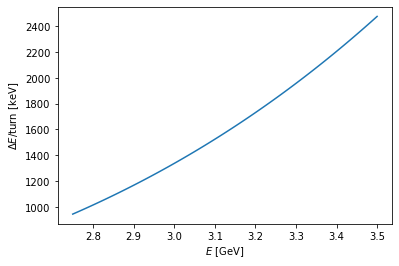

In [19]:
beamEnergyRange = np.linspace(beamEnergyBefore, beamEnergyAfter, 100)
energyLossPerTurn = e0**2*(beamEnergyRange/electronMass)**4/(3*epsilon0*bendingRadius)/e0

plt.figure()
plt.plot(beamEnergyRange/1E9, energyLossPerTurn/1E3)
plt.xlabel("$E$ [GeV]")
plt.ylabel("$\Delta E/$turn [keV]")
plt.show()

## Exercise 2: Average RF power

- What is the average power to the beam before and after the upgrade?
- Plot the required RF power versus beam energy.
- Why should the installed RF power actually be higher?

#### &hookrightarrow; Helpful Hints &hookleftarrow;
1. Average means over a turn.
1. Calculate the revolution frequency and period.
2. The power loss is defined by the energy lost per time. The number of charges can of course be determined from the beam current.

In [20]:
#Electrons therefore beta = 1
circumference = 354.097
revolutionFrequency = c0/circumference

print("Revolution frequency: "+str(revolutionFrequency/1E3)+" kHz")

Revolution frequency: 846.63936153088 kHz


In [21]:
beamCurrent = 500E-3 #A
nElectrons = (beamCurrent/e0)/revolutionFrequency
radiationPowerBefore = energyLossPerTurnBefore*revolutionFrequency*nElectrons*e0

print(f"Average power to beam before upgrade: "+str(radiationPowerBefore/1E3)+" kW")

Average power to beam before upgrade: 471.95041042338727 kW


In [22]:
beamCurrent = 800E-3 #A
nElectrons = (beamCurrent/e0)/revolutionFrequency
radiationPowerAfter = energyLossPerTurnAfter*revolutionFrequency*nElectrons*e0

print(f"Average power to beam before upgrade: "+str(radiationPowerAfter/1E3)+" kW")

Average power to beam before upgrade: 1981.3342768198727 kW


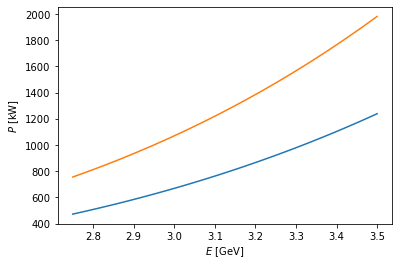

In [23]:
beamEnergyRange = np.linspace(beamEnergyBefore, beamEnergyAfter, 100)
energyLossPerTurn = e0**2*(beamEnergyRange/electronMass)**4/(3*epsilon0*bendingRadius)/e0

beamCurrent = 500E-3
radiationPowerBeforeCurrent = energyLossPerTurn*revolutionFrequency*beamCurrent/revolutionFrequency

beamCurrent = 800E-3
radiationPowerAfterCurrent = energyLossPerTurn*revolutionFrequency*beamCurrent/revolutionFrequency

plt.figure()
plt.plot(beamEnergyRange/1E9, radiationPowerBeforeCurrent/1E3)
plt.plot(beamEnergyRange/1E9, radiationPowerAfterCurrent/1E3)
plt.xlabel("$E$ [GeV]")
plt.ylabel("$P$ [kW]")
plt.show()

## Exercise 3: Chose RF frequency. Arguments?

- Choose the RF frequency and harmonic of the additional RF system.
- Note a few arguments supporting your choice.

#### &hookrightarrow; Helpful Hints &hookleftarrow;
Many solutions are possible. Your beam dynamics and engineering arguments count!

In [24]:
minimumFrequency = 1/25E-9
minimumHarmonic = minimumFrequency/revolutionFrequency
print("Minimum frequency: "+str(minimumFrequency/1E6)+" MHz")
print("40 MHz/revolution frequency at extraction: "+str(minimumHarmonic))

Minimum frequency: 40.0 MHz
40 MHz/revolution frequency at extraction: 47.24561816695202


In [25]:
chosenHarmonic = 2*416
chosenFrequency = chosenHarmonic*revolutionFrequency
bucketSpacing = 1/chosenFrequency

print("Bucket spacing: "+str(bucketSpacing*1E9)+" ns")

Bucket spacing: 1.419639968958895 ns


- Must be integer harmonic of existing RF system ($h=416$)
- Chose twice that frequency ($h=832$, $f_\mathrm{RF} = 704$ MHz) to generate additional voltage more easily and with compact cavities

## Exercise 4: RF cavity, number of cavities, RF amplifier power

- Choose an approriate type of RF cavity.
- How many cavities would you install?
- Please note some arguments for the discussion.

#### &hookrightarrow; Helpful Hints &hookleftarrow;
Again, there are many correct answers. No calculation is required for this part and everything depends on the arguments.

- Choose frequency above 40 MHz to generate 1.5 MV in addition
- 40 MHz would be too low to efficiently obtain high voltage
    - RF frequency unnecessarily low
    - Cavities would be too large
- Chose multiple of the existing RF system at $h=416$


- Vacuum resonator at fixed frequency
- Bell-shape: avoid multipactor and higher order modes
- Moderate $R/Q$

## Exercise 5: Requirements for beam loading: beam induced voltage and power

- Calculate the beam induced voltage and power in the additional cavity.
- How does the power compare to the power lost by synchrotron radiation?
- Under which circumstances do you really need that power?

In [26]:
RUponQ = 44
VInduced = nElectrons*e0*RUponQ*chosenHarmonic*revolutionFrequency*2*np.pi

print("Beam loading induced voltage: "+str(VInduced/1E3)+" kV")

Beam loading induced voltage: 184.01187818018423 kV


In [27]:
beamCurrent = 800E-3 #A
beamLoadingPower = VInduced*beamCurrent

print(f"Beam loading power (flat top): "+str(beamLoadingPower/1E3)+" kW")

Beam loading power (flat top): 147.2095025441474 kW


- This would only be needed to fully compensate beam loading
- Detune RF cavities such that the system of power generator and beam is resonant at $832 f_\mathrm{rev}$

## Exercise 6: Beam life time with no RF

- How many turns would the beam survive without RF? For a first estimate one can assume a constant energy loss. The momentum acceptance is on the order of 0.5%.
- Optionally: take into account the energy loss per turn changes with beam energy.
- Plot the beam energy versus number of turns.

In [28]:
momentumRatioAcceptance = 0.5E-2
beamEnergy = 2.75E9 #eV

designMomentum = np.sqrt(beamEnergy**2 - electronMass**2)
lossMomentum = designMomentum*(1 - momentumRatioAcceptance)
lossEnergy = np.sqrt(lossMomentum**2 + electronMass**2)

energyLossPerTurn = e0**2*(beamEnergy/electronMass)**4/(3*epsilon0*bendingRadius)/e0

print("Momentum at which particles are lost: "+str(lossMomentum/1E9)+" GeV/c")
print("Energy at which particles are lost:   "+str(lossEnergy/1E9)+" GeV")

nTurnsUntilLost = (beamEnergy - lossEnergy)/energyLossPerTurn
lifeTime = nTurnsUntilLost/revolutionFrequency

print("Life time (before upgrade): "+str(lifeTime*1E6)+" us ("+str(nTurnsUntilLost)+" turns)")

Momentum at which particles are lost: 2.7362499527610313 GeV/c
Energy at which particles are lost:   2.7362500004759562 GeV
Life time (before upgrade): 17.205918592325006 us (14.567207931558341 turns)


In [29]:
momentumRatioAcceptance = 0.5E-2
beamEnergy = 3.5E9 #eV

designMomentum = np.sqrt(beamEnergy**2 - electronMass**2)
lossMomentum = designMomentum*(1 - momentumRatioAcceptance)
lossEnergy = np.sqrt(lossMomentum**2 + electronMass**2)

energyLossPerTurn = e0**2*(beamEnergy/electronMass)**4/(3*epsilon0*bendingRadius)/e0

print("Momentum at which particles are lost: "+str(lossMomentum/1E9)+" GeV/c")
print("Energy at which particles are lost:   "+str(lossEnergy/1E9)+" GeV")

nTurnsUntilLost = (beamEnergy - lossEnergy)/energyLossPerTurn
lifeTime = nTurnsUntilLost/revolutionFrequency

print("Life time (after upgrade): "+str(lifeTime*1E6)+" us ("+str(nTurnsUntilLost)+" turns)")

Momentum at which particles are lost: 3.4824999628836673 GeV/c
Energy at which particles are lost:   3.4825000003739657 GeV
Life time (after upgrade): 8.34587388838258 us (7.0659453402774695 turns)


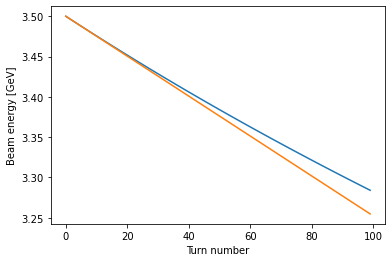

In [30]:
beamEnergyInitial = 3.5E9
nTurns = 100
turnRange = np.array(range(nTurns))
energyTurnByTurn = np.zeros(nTurns)
energyLossPerTurnInitial = e0**2*(beamEnergyInitial/electronMass)**4/(3*epsilon0*bendingRadius)/e0

beamEnergy = beamEnergyInitial
for turn in turnRange:
    energyTurnByTurn[turn] = beamEnergy
    energyLossPerTurn = e0**2*(beamEnergy/electronMass)**4/(3*epsilon0*bendingRadius)/e0
    beamEnergy = beamEnergy - energyLossPerTurn
    
plt.figure()
plt.plot(turnRange, energyTurnByTurn/1E9)
plt.plot(turnRange, (beamEnergyInitial - turnRange*energyLossPerTurnInitial)/1E9)
plt.xlabel("Turn number")
plt.ylabel("Beam energy [GeV]")
plt.show()

## Exercise 7: Radiation damping time

- Calculate the damping times of the synchrotron oscillations before and after the upgrade.

In [31]:
revolutionTime = 1/revolutionFrequency
momentumCompationFactor = 4.16E-4
dampingIntegralD = momentumCompationFactor * circumference/(2*np.pi*bendingRadius)

print("D = "+str(dampingIntegralD)+" (well below one, 2+D can be approximate to 2)")

dampingTimeBefore = beamEnergyBefore*revolutionTime/energyLossPerTurnBefore  #not radiationPowerBefore (which is for the whole beam)
dampingTimeAfter  = beamEnergyAfter*revolutionTime/energyLossPerTurnAfter   #not radiationPowerAfter

print("SR Damping time before: "+str(dampingTimeBefore*1E3)+" ms")
print("SR Damping time after:  "+str(dampingTimeAfter*1E3)+" ms")

D = 0.004373920850699349 (well below one, 2+D can be approximate to 2)
SR Damping time before: 3.441183837581627 ms
SR Damping time after:  1.6691748133458983 ms


## Exercise 8: Comparison with RF system at ESRF

- Compare the parameters of the (additional) RF system with the one of the storage ring at ESRF.

| Parameter                       | Unit | ESRF  | Soleil | Soleil (CAS upgrade) |
| ------------------------------- | ---- | ----- | ------ | -------------------- |
| Beam energy, $E$                | GeV  | 6     | 2.75   | 3.5                  |
| Beam current, $I_\mathrm{beam}$ | mA   | 200   | 500    | 800                  |
| Circumference, $2 \pi R$        | m    | 844   | 354    | 354                  |
| Bending radius, $\rho$          | m    | 23.37 | 5.36   | 5.36                 |
| RF harmonic, $h$                |      | 992   | 416    | 416 and 832          |
| RF frequency, $f_\mathrm{RF}$   | MHz  | 352   | 352    | 352 and 704          |
| RF voltage, $V_\mathrm{RF}$     | MV   | 6.5   | 3      | 3 + >1.5             |
| Number of cavities              |      | 14    | 4      | 4 + ~4               |